# 2017 Work Analysis

As part of my normal routine I track all of the time I spend working on software-related projects and the time I spend playing my trumpet.

Originally this was started as a way to make sure that **the time spent on side-projects did not impact the time I spent on my day job**. I wanted to make sure the my excitement for my hobbies was not taking away from the commitment I had to my team, and to the company through which I was making a living.

I also tracked my time to make sure I was aware of **how much I was actually working**. With the commute time and a small team, it can be hard to be aware of how much time is actually passing. It's easy to overwork or underwork because of inconsistent reference points. I didn't want small changes in my schedule to result in significant decreases in total work.

In addition to making sure I was following through on my commitments, I really like the fact that I have data on the work I do. I like the graphs, and think it's cool to be able to look back and see what I spent my time on.

# Table of Contents

1. [Referenced Projects](#Referenced-Projects)
1. [Tracking Details](#Tracking-Details)
1. [Dependencies](#Dependencies)
1. [Notebook Configuration](#Notebook-Configuration)
1. [External Resources and Constants](#External-Resources-and-Constants)
1. [FileIO and Data Store](#FileIO-and-Data-Store)
1. [Working Hours](#Working-Hours)
1. [All 2017 Work](#All-2017-Work)
1. [Lunch](#Lunch)
1. [Weekly Hours](#Weekly-Hours)
1. [Overtime Calculations](#Overtime-Calculations)
1. [Conclusion](#Conclusion)

# Graphs

* [Working Hours](#Working-Hours-Results)
* [All 2017 Work](#All-2017-Work-Results)
* [Lunch](#Lunch-Results)
* Weekly Hours
    * [All Hours](#Weekly-Hours-Results)
    * [With Side Project Filtering](#Weekly-Hours-with-Side-Project-Filtering)
    * [by Quarter](#Weekly-Hours-by-Quarter)
    * [by Month](#Weekly-Hours-by-Month)
* [Overtime](#Overtime-Results)
* [Appendix 1: 2016 vs 2017](#Appendix-1)

# Referenced Projects

## Day Job

### SkinIO 

> SkinIO is my day job, and where I spend the majority of my time. You can find more information [here](https://www.skinio.com/). In brief, it's early-warning skin cancer detection software. It uses computer vision and machine learning technology to help patients and dermatologists track changes in skin lesions over time. I'm the lead engineer at SkinIO, and run the tech team.

## Side Projects

### Uplink

> Uplink Sports is a digitial marketing app I built and designed with my [brother](https://twitter.com/MattTornquist). You can find more information [here](http://www.uplinkapp.com/) and [here](https://twitter.com/UplinkApp). It allows people to quickly and effectively design sports marketing material from the field. The targeted audience is smaller programs (high schools, DII, DIII, etc.) that otherwise would not have access to a graphics design department.

### Quest

> Quest or NavQuest (as the iOS App is named) is a scavenger hunt app I designed and used when proposing to my girlfriend (now fiancée). More information [here](https://github.com/Tornquist/Quest). It has a well defined JSON spec if you want to make your own quests.

### Wedding

> Time spent on wedding-related tech, ie: the website. I'm bad at web-design, and it took much more time than I planned.

### Other

> This includes discussions about a new initiative with a friend of mine in early 2017, time spent planning and prototyping a tool to scrape twitter analytics, and just other tech-related playing around. Any project that turned into a real quantity of time was broken out on its own.

## Tracking Details

The time tracking is not perfect, but I am careful to keep as accurate of records as possible. This data is for me, and I try my best to avoid inflating or deflating values. My general rule of thumb is that things over a few minutes get tracked. I'll respond to Slack messages, check server state, etc. without reporting time. Should that check turn into something more involved I will occasionally backfill the information.

Outside of my engineering work, the only other data I track with this system is my trumpet. I do not play as much as I would like, and I find it helpful to see the weeks and months since I've last played as a reminder that I'm long overdue.

## Dependencies

I'm using pandas to manage the csv data, numpy/scipy to analyze the data (as well as manual analysis), and matplotlib to plot the results. All of the dependencies are imported here.

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.mlab as mlab
import matplotlib.colors as colors

from scipy.stats import norm
import math

import datetime
import copy

from enum import Enum
from operator import add

import calendar

## Notebook Configuration

In [2]:
%matplotlib inline

## External Resources and Constants

In [3]:
FILENAME = '2017-Records.csv'

In [4]:
class Day(Enum):
    SUN = "Sunday"
    MON = "Monday"
    TUE = "Tuesday"
    WED = "Wednesday"
    THU = "Thursday"
    FRI = "Friday"
    SAT = "Saturday"
    
class Week(Enum):
    FULL = [Day.SUN, Day.MON, Day.TUE, Day.WED, Day.THU, Day.FRI, Day.SAT]
    WORK = [Day.MON, Day.TUE, Day.WED, Day.THU, Day.FRI]

    def days(self):
        return self.value
    
    def day_names(self):
        return list(map(lambda day: day.value, self.value))

class Project(Enum):
    UPLINK = "Uplink"
    SKINIO = "SkinIO"
    TRUMPET = "Trumpet"
    ALEXANDRIA = "Alexandria"
    QUEST = "Quest"
    SCINTILLOMETER = "Scintillometer"
    WEDDING_WEBSITE = "Wedding Website"
    OTHER = "Other"
    
    def numerical_value(self):
        return {
            Project.SKINIO: 1,
            Project.UPLINK: 2,
            Project.TRUMPET: 3,
            Project.QUEST: 4,
            Project.WEDDING_WEBSITE: 5,
            Project.ALEXANDRIA: 6,
            Project.SCINTILLOMETER: 6, 
            Project.OTHER: 6
        }[self]
    
    def is_job(self):
        return self == Project.SKINIO

    def is_side_project(self):
        return self in [
            Project.UPLINK,
            Project.ALEXANDRIA,
            Project.QUEST,
            Project.SCINTILLOMETER,
            Project.WEDDING_WEBSITE
        ]
    
    def is_work(self):
        return self.is_job() or self.is_side_project()
    
    @staticmethod
    def get_from(project, task):
        clean_project = project.strip()
        clean_task = task.strip()
        
        if (clean_project == "Uplink"):
            return Project.UPLINK
        elif (clean_task == "SkinIO"):
            return Project.SKINIO
        elif (clean_project == "Trumpet"):
            return Project.TRUMPET
        elif (clean_project == "Alexandria"):
            return Project.ALEXANDRIA
        elif (clean_project == "Quest"):
            return Project.QUEST
        elif (clean_project == "Scintillometer"):
            return Project.SCINTILLOMETER
        elif (clean_project == "Wedding Website"):
            return Project.WEDDING_WEBSITE
        else:
            return Project.OTHER
    
    @staticmethod
    def jobs():
        return list(filter(lambda project: project.is_job(), Project.all()))

    @staticmethod
    def side_projects():
        return list(filter(lambda project: project.is_side_project(), Project.all()))
    
    def work():
        return list(filter(lambda project: project.is_work(), Project.all()))
    
    @staticmethod
    def all():
        return [
            Project.UPLINK,
            Project.SKINIO,
            Project.TRUMPET,
            Project.ALEXANDRIA,
            Project.QUEST,
            Project.SCINTILLOMETER,
            Project.WEDDING_WEBSITE,
            Project.OTHER
        ]

class Key(Enum):
    DATE = "date"
    DAY = "day"
    PROJECT = "project"
    START = "start"
    END = "end"
    AMOUNT = "amount"
    
HIST_COLOR = (42/255.0, 111/255.0, 177/255.0, 1)

## FileIO and Data Store

Entry is used to hold the data throughout the project. It's a direct mapping from the pandas data frame, but uses the constants and enums defined above to avoid having to verify keys throughout the rest of the project. The other methods here are just helpers to pull in and format the data.

In [5]:
class Entry:
    def __init__(self, date, day, project, start, end, amount):
        self.date = date
        self.day = day
        self.project = project
        self.start = start
        self.end = end
        self.amount = amount

class FileHelper:
    def read_data(name=FILENAME):
        data = pd.read_csv(name)
        return data
    
    def reformat_data(data):
        columns = list(data.columns.values)

        date_index = columns.index("date")
        day_index = columns.index("day")

        project_index = columns.index("project")
        task_index = columns.index("task")

        start_index = columns.index("start")
        end_index = columns.index("end")

        amount_index = columns.index("amount_decimal")

        formatted = []
        for row in data.values:
            date = row[date_index]
            day = Day(row[day_index])

            project_raw = row[project_index]
            task_raw = row[task_index]
            project = Project.get_from(project_raw, task_raw)

            start = row[start_index]
            end = row[end_index]

            amount = row[amount_index]

            entry = Entry(date, day, project, start, end, amount)

            formatted.append(entry)
        return formatted

    def get_data(filename=None):
        data = FileHelper.read_data() if filename == None else FileHelper.read_data(filename)
        return FileHelper.reformat_data(data)

    def get_by_project(project, filename=None):
        data = FileHelper.get_data(filename)
        return list(filter(lambda entry: entry.project == project, data))

# Working Hours

One of my favorite parts of Github is the extremely addictive commit/activity graph. I like filling in the holes and when I'm working on projects, I aim to commit once a day or at the least every other day.

To start with, I'm curious what that looks like for my working time, not just my commit timestamps.

In [6]:
class WorkingHours:
    def get_working_hours(filter=None, groups_per_hour = 12):
        data = FileHelper.get_data if filter == None else FileHelper.get_by_project(filter)
        complete_data = {
            Day.SUN: [0]*(24*groups_per_hour),
            Day.MON: [0]*(24*groups_per_hour),
            Day.TUE: [0]*(24*groups_per_hour),
            Day.WED: [0]*(24*groups_per_hour),
            Day.THU: [0]*(24*groups_per_hour),
            Day.FRI: [0]*(24*groups_per_hour),
            Day.SAT: [0]*(24*groups_per_hour),
        }

        for entry in data:
            start_time = datetime.datetime.strptime(entry.start, '%I:%M %p')
            end_time = datetime.datetime.strptime(entry.end, '%I:%M %p')

            start_minute_offset = round(start_time.minute/(60/groups_per_hour))
            end_minute_offset = round(end_time.minute/(60/groups_per_hour))
            
            start_time_index = start_time.hour * groups_per_hour + start_minute_offset
            end_time_index = end_time.hour * groups_per_hour + end_minute_offset

            for time_index in range(start_time_index, end_time_index + 1):
                complete_data[entry.day][time_index] += 1
        return complete_data
    
    def calculate_upscale(entries_per_day, days):
        """ 
        matshow displays matrices in their native ratio. To get this to display well, the data
        will be padded. That will make each cell rectangular, but will make interpretation of
        the graph much easier. SkinIO is used as a seed, but any project could be used.
        
        This upscale value is what should be later fed into configure_for_display.
        """
        target_ratio = 3
        current_ratio = entries_per_day/days
        upscale = round(current_ratio/target_ratio)
        return upscale
    
    def configure_for_display(working_hours, days, upscale):
        result = []
        for day in days:
            for _ in range(upscale if upscale > 0 else 1):
                result.append(working_hours[day])
        return result

    def merge(working_hours_set):
        result = None
        for working_hours in working_hours_set:
            if (result == None):
                result = copy.deepcopy(working_hours)
            else:
                for index in range(0, len(result)):
                    result[index] = list(map(add, result[index], working_hours[index]))
        return result
    

For this test I'm going to analyze the entire week and use 6 groups per hour. That means the results will be drawn in 10 minute interfals. I found that 10 min showed good divisions for lunch breaks and variable starts/ends to the day without being so fine that all clarity was lost.

In [7]:
WEEK_TYPE = Week.FULL
GROUPS_PER_HOUR = 6

I need to calculate the working hours for all projects

In [8]:
working_hours = {}
for project in Project:
    working_hours[project] = WorkingHours.get_working_hours(project, GROUPS_PER_HOUR)

Because of the way matshow displays matricies, in correct aspect ratios, I need to upsample the data. This will convert the cells to rectangles, but it will also make the graph tall enough that the data is actually visible. Otherwise the graph would be 144 entries (24 hours * 6 groups/hour) by 7. 144:7 does not display well.

The upsampled data will be a 2d array instead of the dictionary used as input.

In [9]:
entries_per_day = len(working_hours[Project.SKINIO][Day.MON])
num_days = len(WEEK_TYPE.days())
upscale = WorkingHours.calculate_upscale(entries_per_day, num_days)

display_data = {}
for key in working_hours:
    display_data[key] = WorkingHours.configure_for_display(
        working_hours[key],
        WEEK_TYPE.days(),
        upscale
    )

The final step is to group by day job, side projects, and all work so that the graphs are ready. The axis labels and offsets also need to be calculated and will be shared between the resulting graphs.

In [10]:
# Final Data
def build_set(projects):
    results = []
    for project in projects:
        results.append(display_data[project])
    return results

day_job_set = build_set(Project.jobs())
day_job = WorkingHours.merge(day_job_set)

side_projects_set = build_set(Project.side_projects())
side_projects = WorkingHours.merge(side_projects_set)

all_work_set = build_set(Project.work())
all_work = WorkingHours.merge(all_work_set)

# Labels
ticker_locations = [round(upscale / 2) - 1]
while (ticker_locations[-1] + upscale) < len(display_data[Project.SKINIO]):
    ticker_locations.append(ticker_locations[-1] + upscale)

time_labels = list(map(lambda label: (label if label <= 12 else label - 12), range(24)))

## Working Hours Results

In the results below you can see a pretty clear picture of when I work.  I normally get into the office around 9am, and I leave the office around 5:45pm. There is also a very clear picture of Friday mornings. I'm in a men's group that meets for coffee until 8am, so I normally get into the office a bit earlier.

As far as side-projects are concerned, I normally use Mon-Thursday mornings, as well as evenings and the weekends. That is clear from the graphs below.

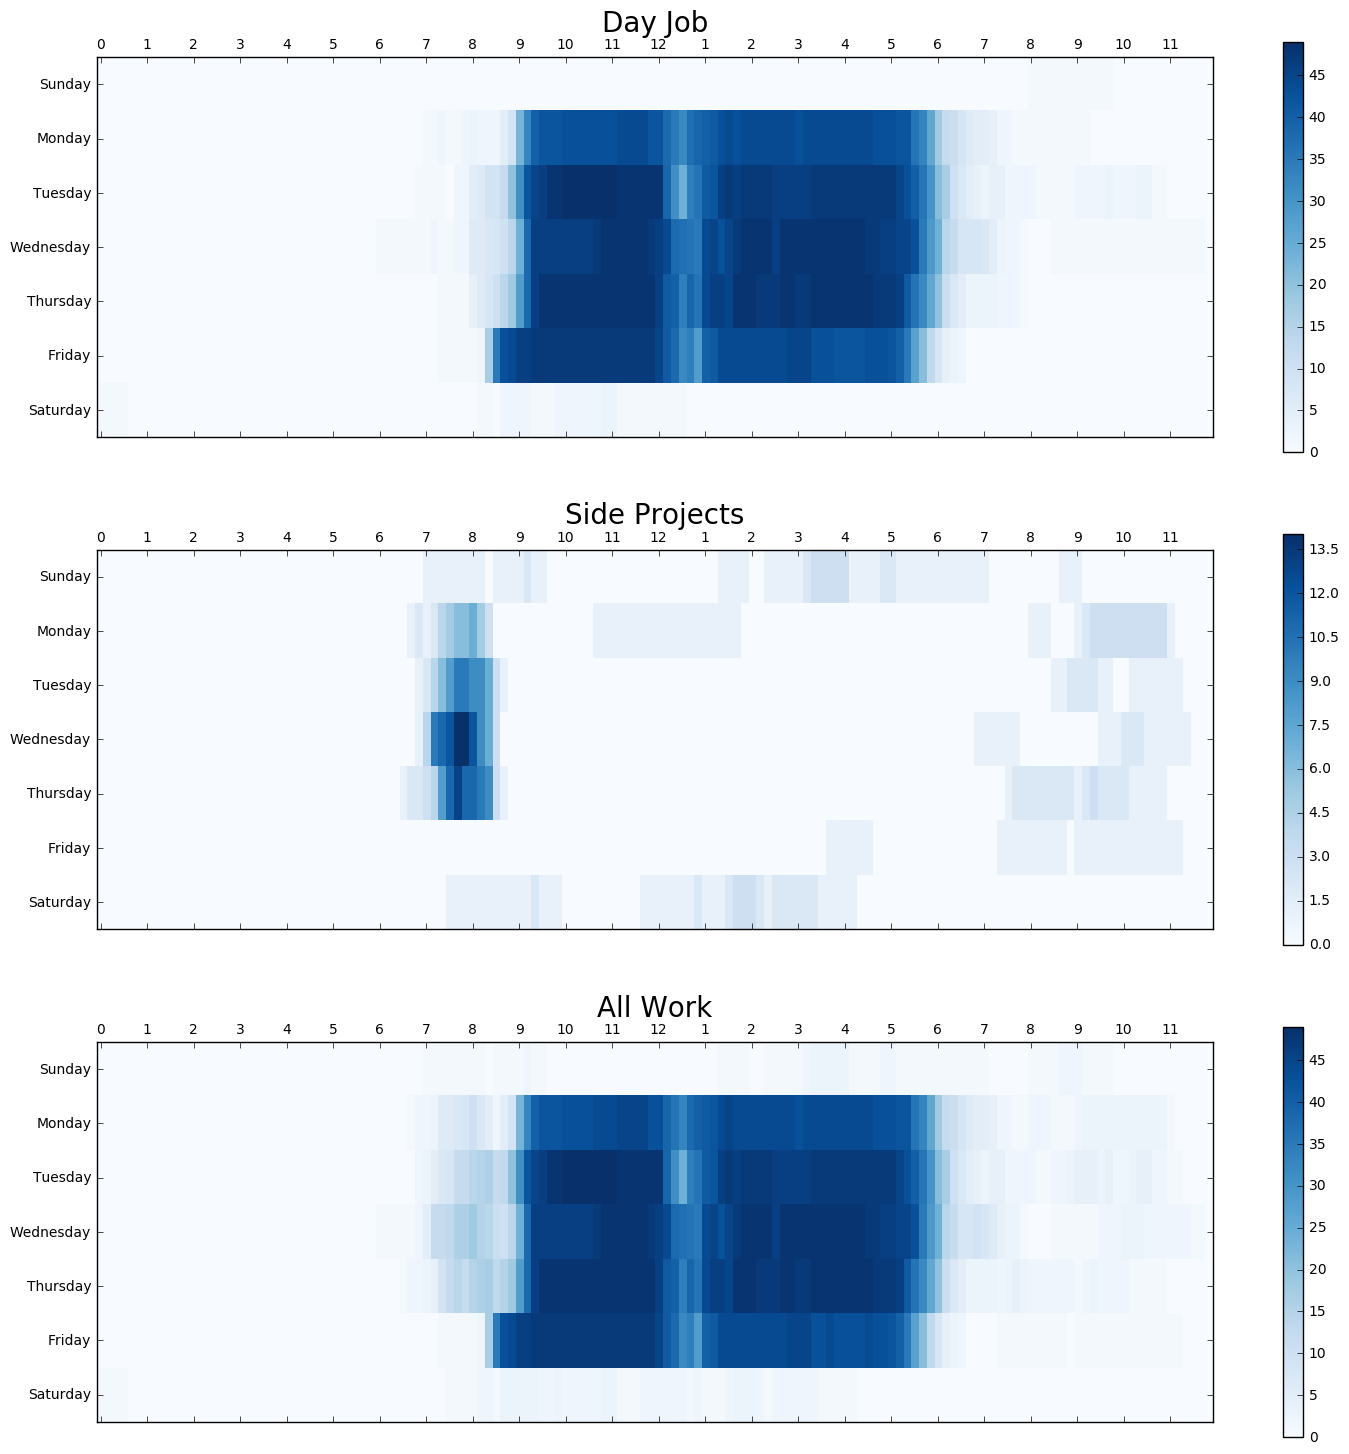

In [11]:
fig = plt.figure(figsize=(18, 18))

ax = fig.add_subplot(311)
ax.set_title("Day Job", fontsize=20)
cax = ax.matshow(day_job, interpolation='nearest', cmap='Blues')
fig.colorbar(cax, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(GROUPS_PER_HOUR))
ax.yaxis.set_major_locator(ticker.FixedLocator(ticker_locations))
ax.set_xticklabels([''] + list(time_labels))
ax.set_yticklabels(list(WEEK_TYPE.day_names()))

ay = fig.add_subplot(312)
ay.set_title("Side Projects", fontsize=20)
cay = ay.matshow(side_projects, interpolation='nearest', cmap='Blues')
fig.colorbar(cay, ax=ay)
ay.xaxis.set_major_locator(ticker.MultipleLocator(GROUPS_PER_HOUR))
ay.yaxis.set_major_locator(ticker.FixedLocator(ticker_locations))
ay.set_xticklabels([''] + list(time_labels))
ay.set_yticklabels(list(WEEK_TYPE.day_names()))

az = fig.add_subplot(313)
az.set_title("All Work", fontsize=20)
caz = az.matshow(all_work, interpolation='nearest', cmap='Blues')
fig.colorbar(caz, ax=az)
az.xaxis.set_major_locator(ticker.MultipleLocator(GROUPS_PER_HOUR))
az.yaxis.set_major_locator(ticker.FixedLocator(ticker_locations))
az.set_xticklabels([''] + list(time_labels))
az.set_yticklabels(list(WEEK_TYPE.day_names()))

plt.show()

# All 2017 Work

After calculating the hours I tend to work, I thought it would be useful to be able to visualize all of my hours over the course of 2017. It's clear that I do side-projects in the morning, and that I have a consistent work schedule. Is that something that is true for the entire year, or is it something that just looks true because I graphed all of the days on top of each other?

Before trying to analyze trends and changes, I wanted to be able to see what my year looked like.

Like the working hours analysis, I'm going to start with some defaults.

In [12]:
GROUPS_PER_HOUR = 6
START_HOUR = 3

With the hourly detail and starting point identified, I'm ready to generate the results for the year.

The `Project` enum has a key `numerical_value()`. Even though the enum is backed by a string, the numerical value is very useful. It lets me fill in the generated `year_matrix` with integer values relating to given projects, and then using a custom colormap I can generated a color-coded graph of my year.

In [13]:
def generate_year_matrix(groups_per_hour, start_hour, year, filename=None):
    days = 366 if calendar.isleap(year) else 365 
    results = np.zeros((groups_per_hour*(24 - start_hour), days))
    for project in Project.work():
        project_data = FileHelper.get_by_project(project, filename)

        for entry in project_data:
            start_time = datetime.datetime.strptime(entry.start, '%I:%M %p')
            end_time = datetime.datetime.strptime(entry.end, '%I:%M %p')

            start_time_minute_offset = round(start_time.minute/(60/groups_per_hour))
            end_time_minuite_offset = round(end_time.minute/(60/groups_per_hour))

            start_time_index = start_time.hour * groups_per_hour + start_time_minute_offset
            end_time_index = end_time.hour * groups_per_hour + end_time_minuite_offset

            start_time_index -= start_hour*groups_per_hour
            end_time_index -= start_hour*groups_per_hour

            date = datetime.datetime.strptime(entry.date, '%m/%d/%y')
            day_of_year = date.timetuple().tm_yday

            for time_index in range(start_time_index, end_time_index + 1):
                results[time_index][day_of_year-1] = entry.project.numerical_value()
    return results

year_matrix = generate_year_matrix(GROUPS_PER_HOUR, START_HOUR, 2017)

## All 2017 Work Results

With the year matrix filled in, it's now pretty straightfoward to graph the matrix. The trends in these results match those found in the [Working Hours Results](#Working-Hours-Results). By spreading the year out, it's also much easier to see trends in my projects, and the normal 2-3 month break between each project I do.

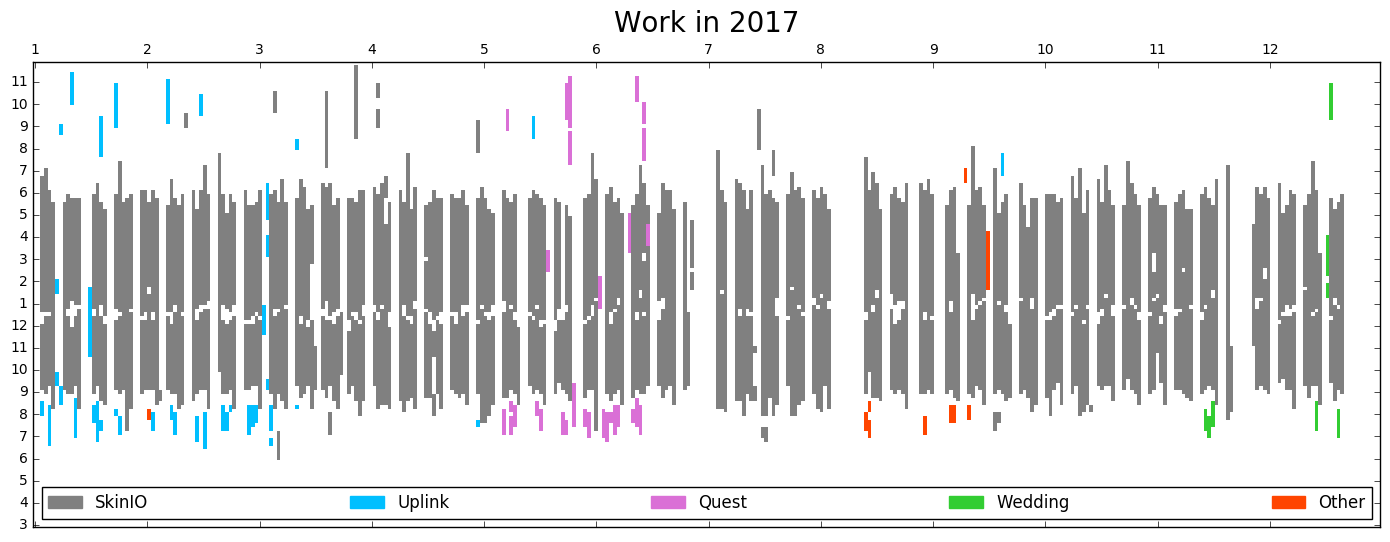

In [14]:
def display_year_matrix(title, matrix, start_hour):
    quest_color = 'orchid'
    uplink_color = 'deepskyblue'
    skinIO_color = 'grey'
    wedding_color = 'limegreen'
    other_color = 'orangered'

    cmap = colors.ListedColormap(['white',
                                  skinIO_color,
                                  uplink_color,
                                  quest_color,
                                  wedding_color,
                                  other_color])

    # Values correspond to Project.numerical_value. 7 is so that the normalization has a max.
    bounds=[0,1,2,4,5,6,7]
    bNorm = colors.BoundaryNorm(bounds, cmap.N)

    hour_labels = range(start_hour - 1, 25)
    hour_labels = list(map(lambda hour: hour if hour <= 12 else hour - 12, hour_labels))
    
    fig = plt.figure(figsize=(18, 6))

    plt.legend(
        handles=[
            mpatches.Patch(color=skinIO_color, label='SkinIO'),
            mpatches.Patch(color=uplink_color, label='Uplink'),
            mpatches.Patch(color=quest_color, label='Quest'),
            mpatches.Patch(color=wedding_color, label='Wedding'),
            mpatches.Patch(color=other_color, label='Other')
        ],
        mode="expand",
        loc=3,
        ncol=5
    )

    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=20)
    cax = ax.matshow(matrix, interpolation='nearest', cmap=cmap, norm=bNorm, origin="lower")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(365/12))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(GROUPS_PER_HOUR))
    ax.set_xticklabels(list(time_labels))
    ax.set_yticklabels(hour_labels)

    plt.show()

display_year_matrix("Work in 2017", year_matrix, START_HOUR)

# Lunch

From the last two exercises it's pretty clear that I have a consistent schedule. I wonder how consistent my lunch duration is?

To calculate this, I'm going to look at all entries that:

* Have no break and are longer than 6 hours --> days I didn't take a lunch that are not half days
* Days with two entries and an end_time before hour 14. (This is to filter one late afternoon coffee-break that skewed the data)

I'm ignoring days with 3 or more entires. I didn't want to reconcile morning or late evening work on top of a normal day.

In [15]:
def calculate_lunch():
    # Get all working entries
    data = FileHelper.get_by_project(Project.SKINIO)

    # Filter weekend entries
    data = list(filter(lambda entry: entry.day in Week.WORK.value, data))
    
    # Group by Date
    data_by_date = {}
    for entry in data:
        if not entry.date in data_by_date:
            data_by_date[entry.date] = []
        data_by_date[entry.date].append(entry)
        
    # Calculate Lunch
    lunch_duration = []
    for date in data_by_date:
        day_data = data_by_date[date]
        entries = len(day_data)
        if (entries == 1):
            # Filter very short days (half days)
            if (entry.amount > 6):
                lunch_duration.append(0)
        elif (entries == 2):
            start_time = datetime.datetime.strptime(day_data[0].end, '%I:%M %p')
            end_time = datetime.datetime.strptime(day_data[1].start, '%I:%M %p')

            if (end_time.hour > 14):
                lunch_duration.append(0)
                continue
            
            delta = end_time - start_time
            duration = delta.seconds / 60
            lunch_duration.append(duration)
        else:
            # These entries are more complicated.
            # This means I worked in the morning, evening, or took another break.
            # Ignoring for now.
            continue
        
    return lunch_duration

## Lunch Results

You can see a few outlines for lunch with friends out of the office, and then a stronger grouping on 20-30 minute breaks.

The biggest surprise here is that if you had asked me how long I take for lunch, I would have said 15 minutes every day. 20 at most. 20 is consistent, but by no means the max. I take longer lunches than I realized.

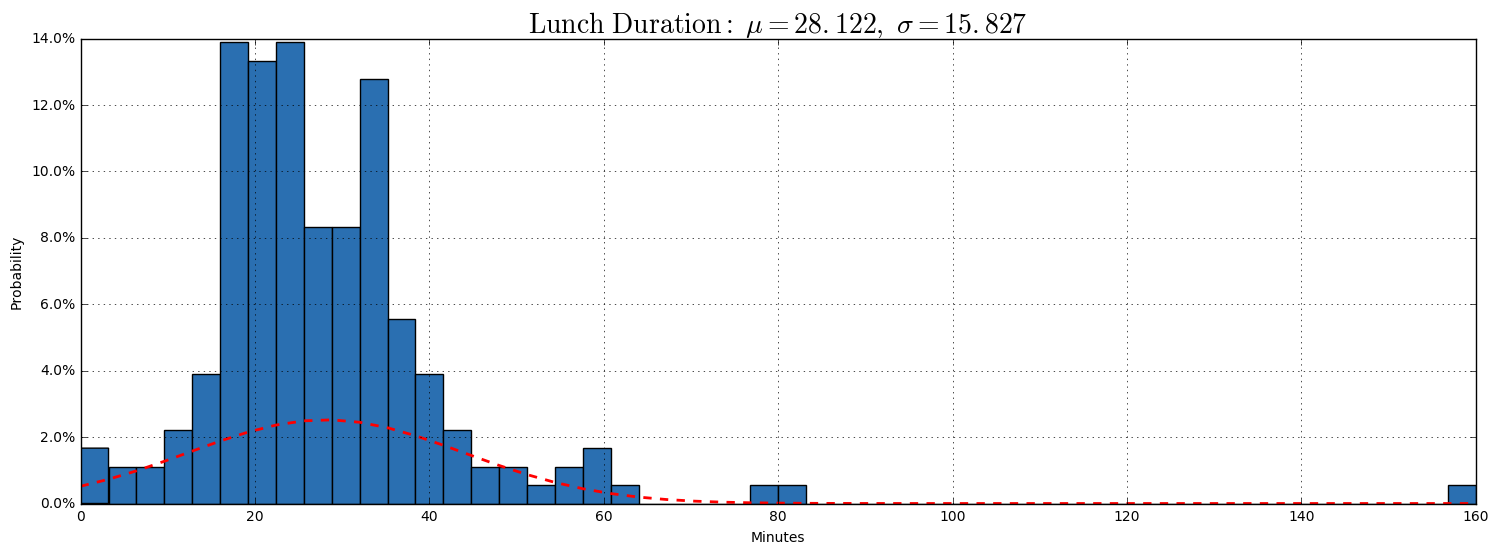

In [16]:
# Calculate Results
lunch = calculate_lunch()
(mu, sigma) = norm.fit(lunch)

# Graph Results

def to_percent(y, position):
    s = str(100 * y)
    return s + '%'

fig = plt.figure(figsize=(18, 6))

weights = np.ones_like(lunch)/float(len(lunch))
n, bins, patches = plt.hist(lunch, 50, facecolor=HIST_COLOR, weights=weights)

y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

plt.xlabel('Minutes')
plt.ylabel('Probability')
plt.title('$\mathrm{Lunch\ Duration:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma), fontsize=20)
plt.grid(True)

formatter = ticker.FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

# Weekly Hours

It is now quite clear that I work a consistent schedule. The next step is confirming what a normal week looks like for me, and then determining if my 'normal' is dependent on the time spent on side-projects.

To run this experiment, I'm going to group all of the data by project by week. This will allow me to quickly analyze against a traditional 40 hr target. From there I can group the weeks to see with and without side-projects and segment by quarter and month.

In [17]:
class WeeklyHours:
    def calculate_composite_hours(project):
        data = FileHelper.get_by_project(project)

        composite_data = {}
        for entry in data:
            date = datetime.datetime.strptime(entry.date, '%m/%d/%y')
            cal = date.isocalendar()

            week = cal[1]
            day = date.day

            # Week 21 is an outlier. I was unable to find why, but I left
            # early one day. It appears to be vacation time, but I don't
            # recall why. It pulls the average down, and was interesting
            # to test the metrics with and without this week.
            # 
            # if (week == 21):
            #     continue

            if (week not in composite_data):
                composite_data[week] = {}
            if (day not in composite_data[week]):
                composite_data[week][day] = 0.0

            composite_data[week][day] += entry.amount

        return composite_data

    def filter_incomplete_weeks(data):
        filtered_data = {}

        for week in data:
            working_days = len(data[week])
            if (working_days >= 5):
                filtered_data[week] = data[week]
        return filtered_data

    def flatten_weeks(data):
        flattened_data = {}
        for week in data:
            hours_per_day = list(map(lambda day: data[week][day], data[week]))
            flattened_data[week] = sum(hours_per_day)
        return flattened_data
    
    def group_by_quarter(data):
        results = {}
        for week in data:
            quarter = math.ceil(week/13.0)
            if quarter not in results:
                results[quarter] = []
            results[quarter].append(data[week])
        return results
    
    def group_by_month(data):
        results = {}
        for week in data:
            month = math.ceil(week/4.3334)
            if month not in results:
                results[month] = []
            results[month].append(data[week])
        return results

First I'm going to look at just the weekly hours. I grab all cumulative hours/per by day. Then I filter incomplete weeks: I'm curious what a full week looks like, not weeks with holidays and vacation time. Then I merge the days into the weeks to end up with a 1-1 mapping of week # and total hours.

In [18]:
composite_hours = WeeklyHours.calculate_composite_hours(Project.SKINIO)
complete_weeks = WeeklyHours.filter_incomplete_weeks(composite_hours)
summed_weeks = WeeklyHours.flatten_weeks(complete_weeks)
hours = list(summed_weeks.values())

## Weekly Hours Results

The results clearly show that I have a fair amount of spread. I'm more likely to work more than 40 hours than I am to work less. 40-45 is a consistent range with light weeks dropping down, and heavy weeks going close to 50. This is what I expected, but it's good to confirm it! Even with a later start time, and a variable lunch, I'm not only consistent with the time I spend at work, but it's the amount of time I'm trying to spend. 40-45, with fluctuation above and below is my target.

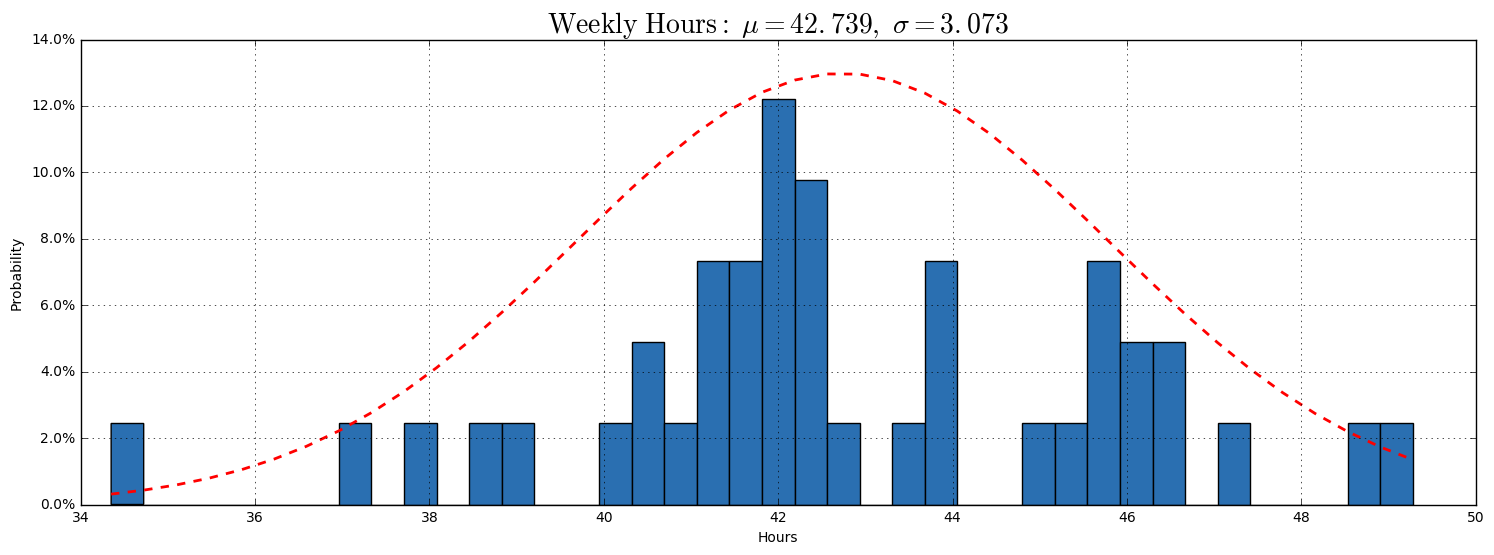

In [19]:
fig = plt.figure(figsize=(18, 6))

weights = np.ones_like(hours)/float(len(hours))
n, bins, patches = plt.hist(hours, 40, facecolor=HIST_COLOR, weights=weights)

(mu, sigma) = norm.fit(hours)
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

plt.xlabel('Hours')
plt.ylabel('Probability')
plt.title('$\mathrm{Weekly\ Hours:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma), fontsize=20)
plt.grid(True)

formatter = ticker.FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

With a baseline established, the next step is to determine if there is a correlation between the weeks I work more and the weeks I work less, and the side-project work that I do. Again, my goal is to (hopefully) see results that show that there is not an impact.

In [20]:
# Calculate All Side Project Data
side_project_data = {}
for project in Project.side_projects():
    project_hours = WeeklyHours.calculate_composite_hours(project)
    flattened_hours = WeeklyHours.flatten_weeks(project_hours)
    side_project_data[project] = flattened_hours


In [21]:
# Generate a list of all weeks in the complete weeks dictionary
week_names = list(complete_weeks.keys())

To see the impact of side-project work on normal hours, I'm only going to look at paired weeks. If I did heavy side-project work on a week that was shorter (holidays, days-off, etc) then I don't want that to skew the other results.

In [22]:
# Merge side project data, filtering by complete full-time weeks
side_project_hours_per_week = {}
for project in side_project_data:
    for week in side_project_data[project]:
        # Week names is the list of weeks in the
        # complete_week set. Defined above
        if week not in week_names:
            continue
        if week not in side_project_hours_per_week:
            side_project_hours_per_week[week] = 0.0

        side_project_hours_per_week[week] += side_project_data[project][week]
        
side_project_week_names = list(side_project_hours_per_week.keys())
side_project_hours = list(side_project_hours_per_week.values())

For the graphed results, I would like to see

1. Spread in normal full-time work
2. Spread of weeks where I **do not** work on side-projects
3. Spread of weeks where I **do** work on side-projects
4. Total spread of all hours (full-time + side-project)

In [23]:
# 2. Spread of weeks where I do not work on side-projects
non_overlapping_hours_by_week = {}
for week in week_names:
    if week in side_project_week_names:
        continue
    non_overlapping_hours_by_week[week] = summed_weeks[week]
non_overlapping_hours = list(non_overlapping_hours_by_week.values())

In [24]:
# 3. Spread of weeks where I do work on side-projects
# 4. Total spread of all hours (sum)
overlapping_hours_by_week = {}
total_when_overlapping_by_week = {}
for week in side_project_week_names:
    overlapping_hours_by_week[week] = summed_weeks[week]
    total_when_overlapping_by_week[week] = summed_weeks[week] + side_project_hours_per_week[week]

overlapping_hours = list(overlapping_hours_by_week.values())
total_when_overlapping = list(total_when_overlapping_by_week.values())

## Weekly Hours with Side-Project Filtering

From the results below you can see that my full-time spread is from 37-49, with an average of around 42.x. Those are the same results that the histogram showed. (As they should be)

When I'm not working on side-projects, there is very little shift in the average, The min moves up slightly, but not very much.  On weeks where I am heavily working on side-projects the average does not drop very far, but the maximum time does decrease.

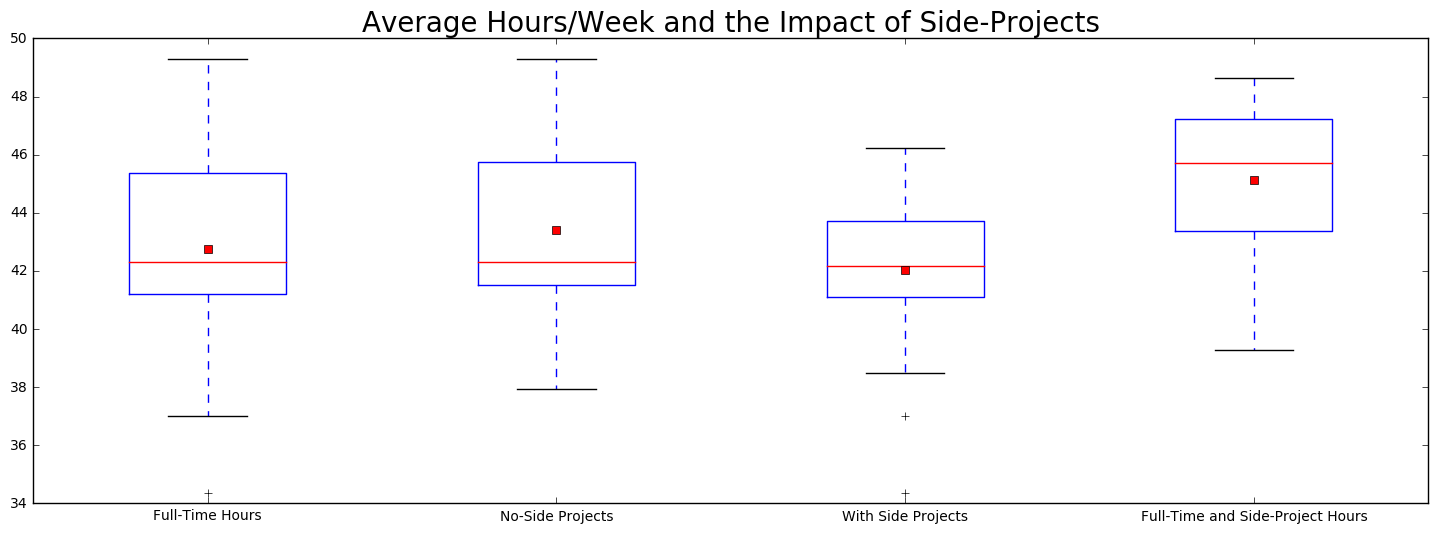

In [25]:
# Graph Results
fig = plt.figure(figsize=(18, 6))

hours_box_data = [
    hours,
    non_overlapping_hours,
    overlapping_hours,
    total_when_overlapping
]
hours_box_data_labels = [
    "Full-Time Hours",
    "No-Side Projects",
    "With Side Projects",
    "Full-Time and Side-Project Hours"
]

ax = fig.add_subplot(111)
ax.set_title("Average Hours/Week and the Impact of Side-Projects", fontsize=20)
ax.boxplot(hours_box_data, showmeans=True, labels=hours_box_data_labels)

plt.show()

With the previous test it is clear that there is an impact on total work time when I'm doing side-projects. It's minor, but it is there. That data is over an entire year though, and from the original [All 2017 Work](#All-2017-Work-Results) graph, it is clear that I don't work on side-projects consistently throughout the entire year.

Because I'm inconsistent, and the type of project that I'm working on changes, it would be interesting to see these same results split by quarter, and by month.

In [26]:
complete_weeks_by_quarter = WeeklyHours.group_by_quarter(summed_weeks)
complete_side_project_weeks_by_quarter = WeeklyHours.group_by_quarter(side_project_hours_per_week)

In [27]:
# Arrange Data for Graphing
    
quarters = list(complete_weeks_by_quarter.keys())
list.sort(quarters)

quarters_box_data = []
for quarter in quarters:
    quarters_box_data.append(complete_weeks_by_quarter[quarter])
    
quarters_side_project_box_data = []
for quarter in quarters:
    quarters_side_project_box_data.append(complete_side_project_weeks_by_quarter[quarter])

## Weekly Hours by Quarter

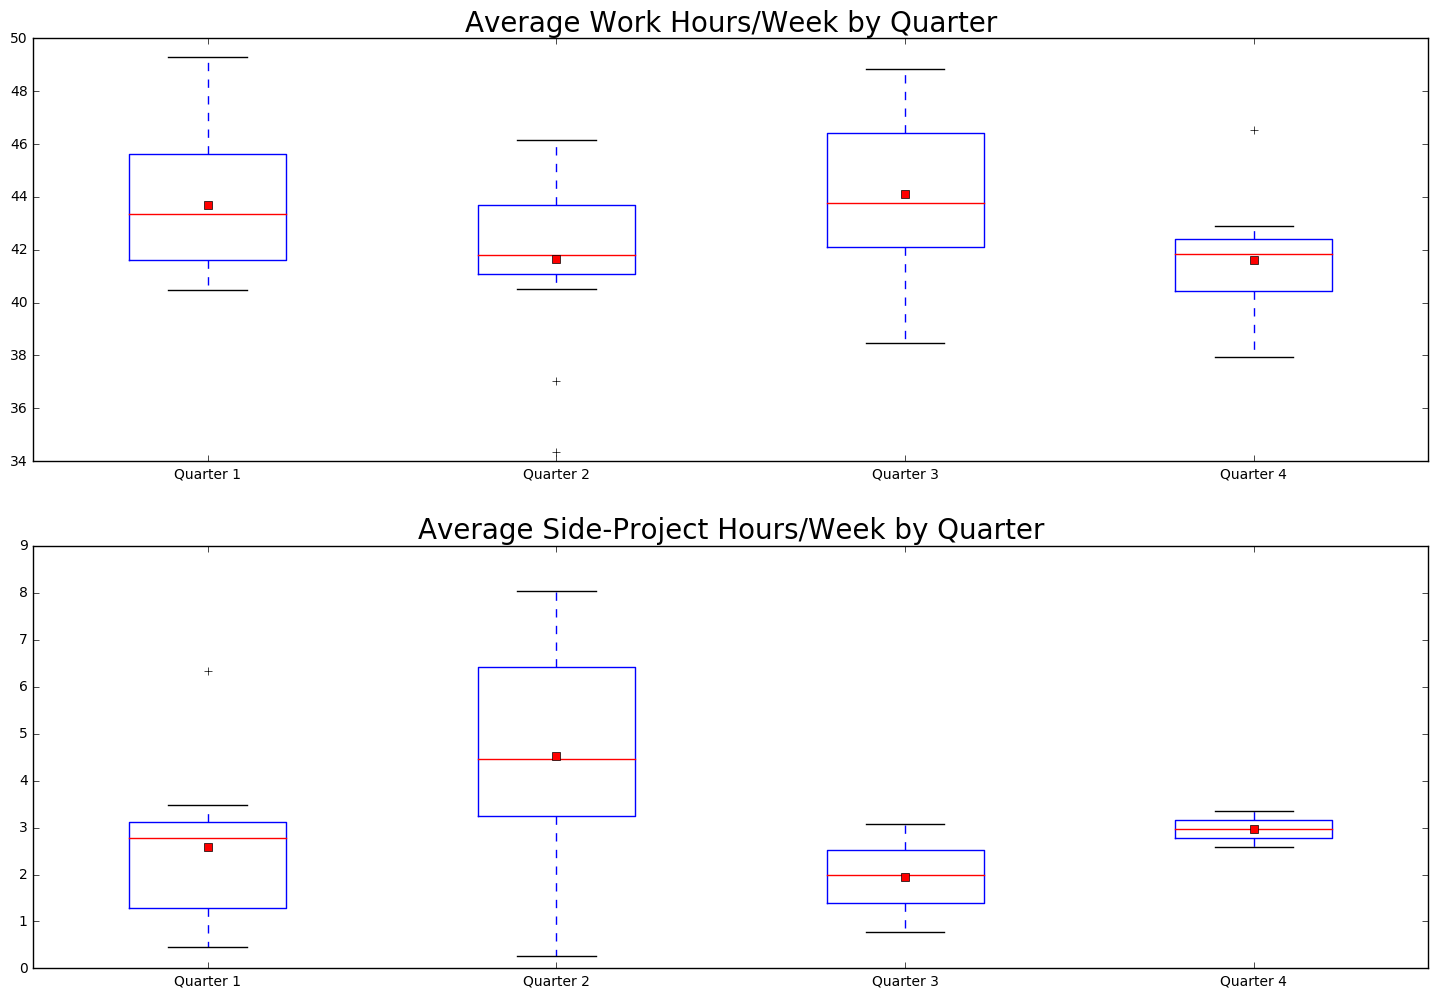

In [28]:
# Graph Results
fig = plt.figure(figsize=(18, 12))

quarters_box_data_labels = list(map(lambda quarter: "Quarter " + str(quarter), quarters))

ax = fig.add_subplot(211)
ax.set_title("Average Work Hours/Week by Quarter", fontsize=20)
ax.boxplot(quarters_box_data, showmeans=True, labels=quarters_box_data_labels)

ay = fig.add_subplot(212)
ay.set_title("Average Side-Project Hours/Week by Quarter", fontsize=20)
ay.boxplot(quarters_side_project_box_data, showmeans=True, labels=quarters_box_data_labels)

plt.show()

These results show the same story. Side-Project work doesn't really impact what is normal, but appears to cut out the most extreme weeks.

In [29]:
complete_weeks_by_month = WeeklyHours.group_by_month(summed_weeks)
complete_side_project_weeks_by_month = WeeklyHours.group_by_month(side_project_hours_per_week)

In [30]:
# Arrange Data for Graphing

months = range(1,13)

months_box_data = []
for month in months:
    months_box_data.append(complete_weeks_by_month[month])
    
months_side_project_box_data = []
for month in months:
    if month in complete_side_project_weeks_by_month:
        months_side_project_box_data.append(complete_side_project_weeks_by_month[month])
    else:
        months_side_project_box_data.append([])

by_month_labels = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]

## Weekly Hours by Month

*Note: These months are estimated. Because I'm grouping by week, there are not clear lines on the breaks between months.*

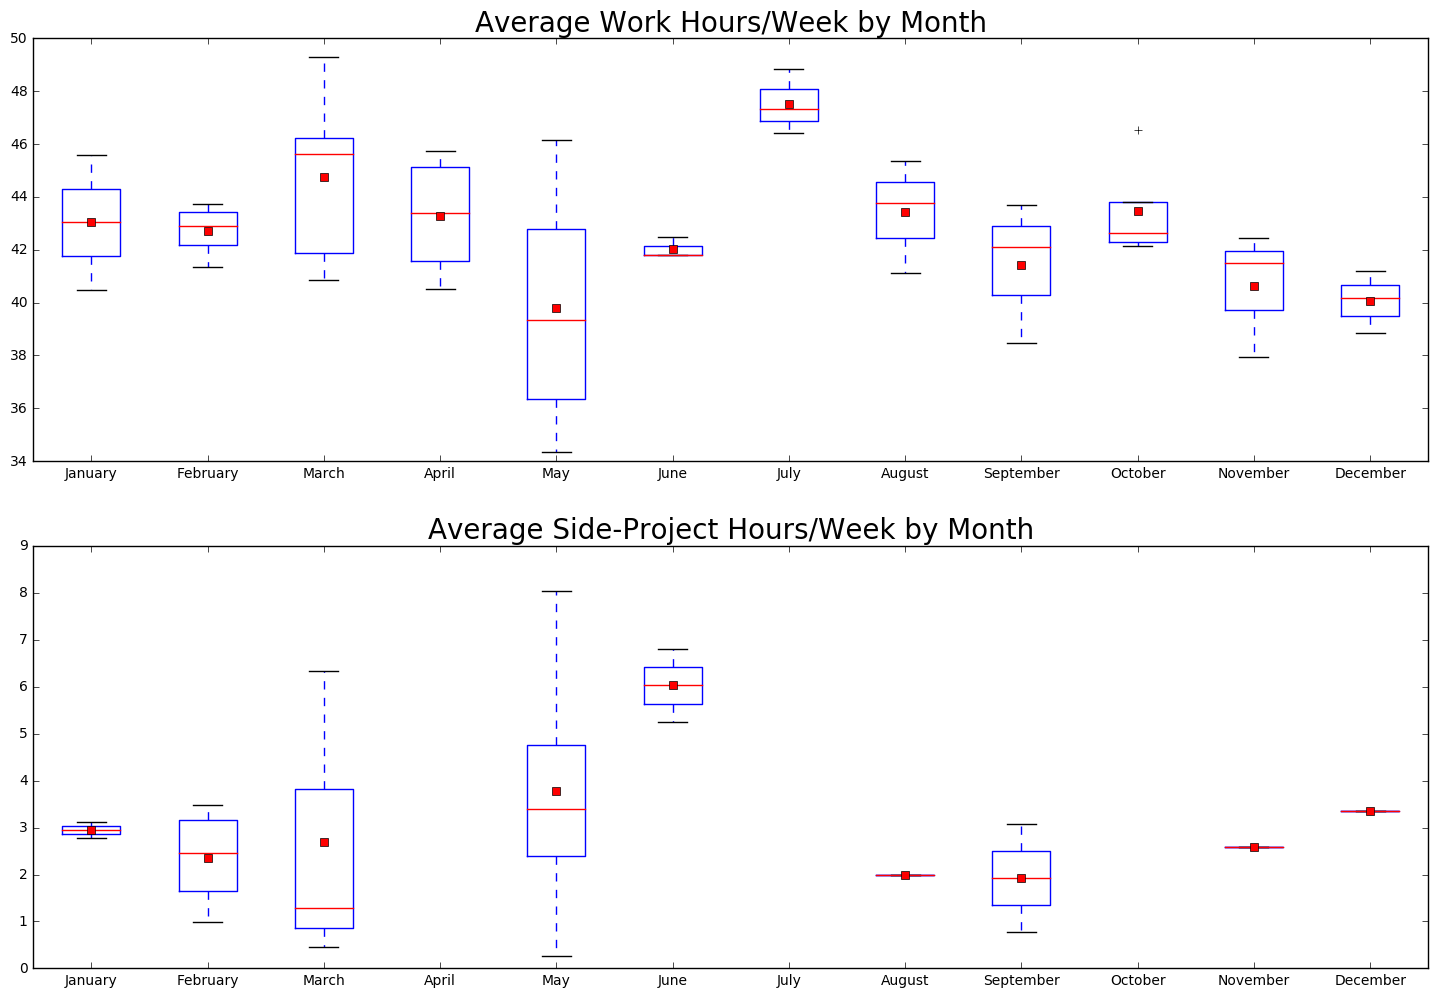

In [31]:
# Graph Results
fig = plt.figure(figsize=(18, 12))

ax = fig.add_subplot(211)
ax.set_title("Average Work Hours/Week by Month", fontsize=20)
ax.boxplot(months_box_data, showmeans=True, labels=by_month_labels)

ay = fig.add_subplot(212)
ay.set_title("Average Side-Project Hours/Week by Month", fontsize=20)
ay.boxplot(months_side_project_box_data, showmeans=True, labels=by_month_labels)

plt.show()

# Overtime Calculations

With the splits by quarter, and by month it's clear that sometimes I drop below 40 hours, and sometimes I go well above. It's also clear that at my peak, side project work may have an impact, but doesn't definitively take away from time spent at work. In the worst case, it seems to lessen my desire to stay later, because I'm not trying to fill all of my time with a single project.

Looking at the average hours/week by month graph, March and May both have high maxes in both categories. May has a lower min, but that's because of week 21, when I took an afternoon off.

The final test now is to see how my weeks with extra time and less time balance out. The goal here is to make sure that at the worst, my cumulative time is at or over the traditional 40 hour expectation. Proving this is one of the two main reasons that I track my hours.

In this test, I want to not only see if my average for complete weeks balances out, but if I'm also covering the time off. Part of the flexibility of my role is lack of defined vacation time. It allows me to take hours, half days, or full days as needed. In that, and in making sure it is not abused, I want to make sure that I make up for the time I take.

In [32]:
# Complete Weeks Only
filtered_overtime_hours = list(map(lambda val: val - 40, hours))

In [33]:
# All Weeks
summed_unfiltered_weeks = WeeklyHours.flatten_weeks(composite_hours)
summed_unfiltered_hours = list(summed_unfiltered_weeks.values())
overtime_hours = list(map(lambda val: val - 40, summed_unfiltered_hours))

## Overtime Results

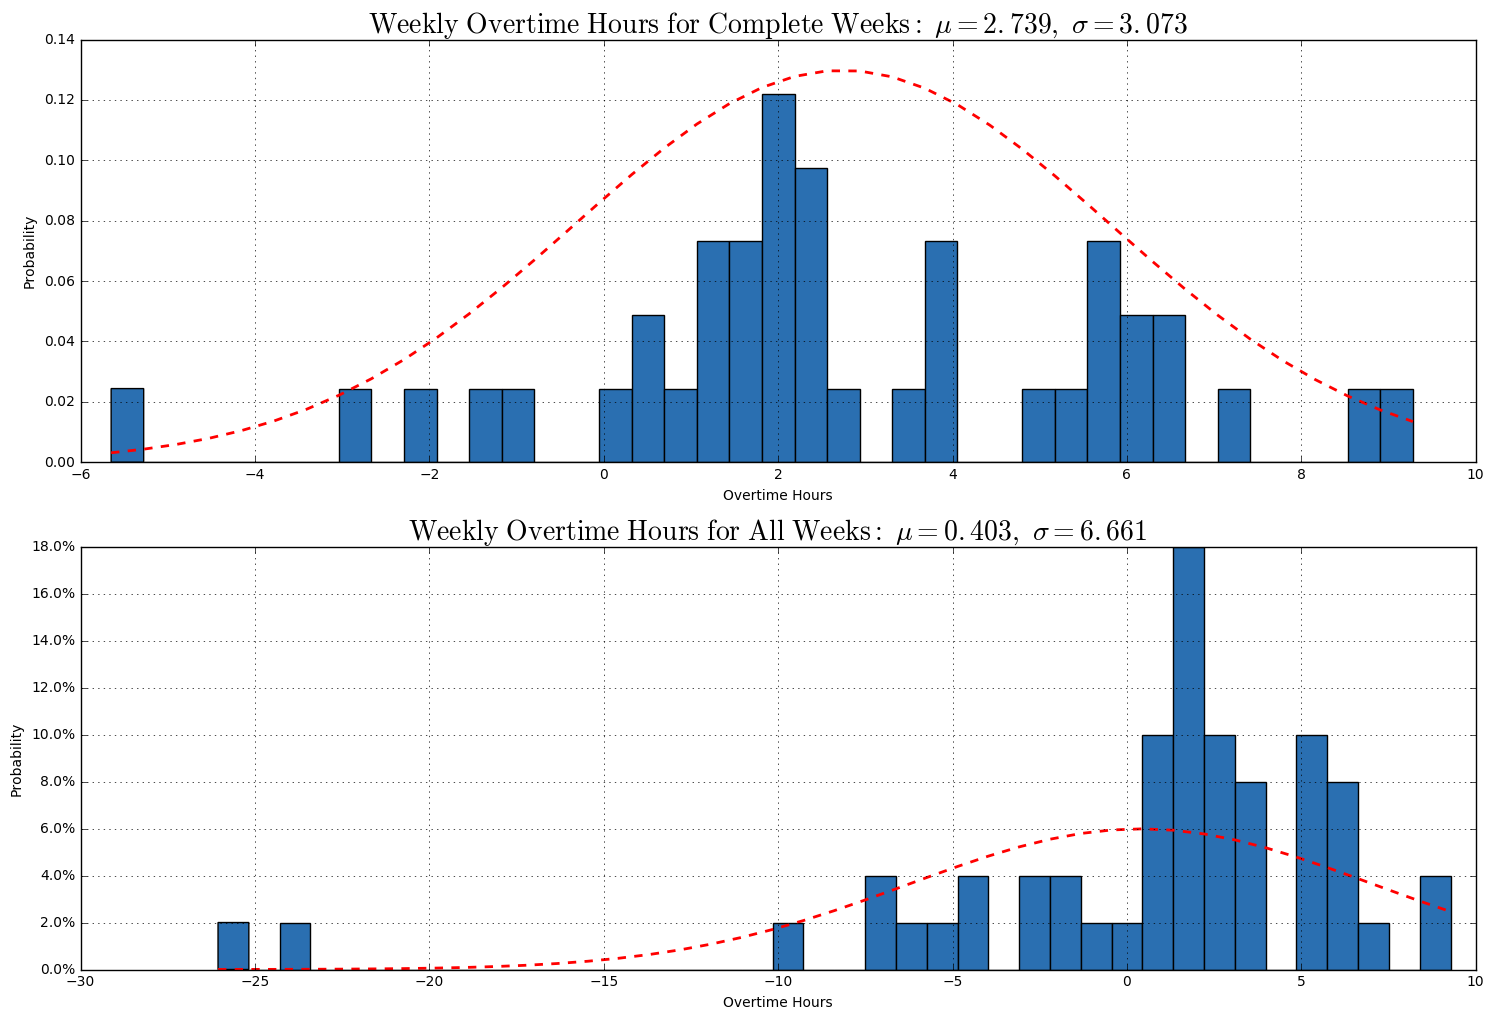

In [34]:
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(211)

weights = np.ones_like(filtered_overtime_hours)/float(len(filtered_overtime_hours))
n, bins, patches = ax.hist(filtered_overtime_hours, 40, facecolor=HIST_COLOR, weights=weights)
(mu, sigma) = norm.fit(filtered_overtime_hours)
y = mlab.normpdf(bins, mu, sigma)
l = ax.plot(bins, y, 'r--', linewidth=2)

ax.set_xlabel('Overtime Hours')
ax.set_ylabel('Probability')
axTitle = '$\mathrm{Weekly\ Overtime\ Hours\ for\ Complete\ Weeks:}\ \mu=%.3f,\ \sigma=%.3f$' %(
    mu,
    sigma)
ax.set_title(axTitle, fontsize=20)
ax.grid(True)

ay = fig.add_subplot(212)

weights = np.ones_like(overtime_hours)/float(len(overtime_hours))
n, bins, patches = ay.hist(overtime_hours, 40, facecolor=HIST_COLOR, weights=weights)
(mu, sigma) = norm.fit(overtime_hours)
y = mlab.normpdf(bins, mu, sigma)
l = ay.plot(bins, y, 'r--', linewidth=2)

ay.set_xlabel('Overtime Hours')
ay.set_ylabel('Probability')
ayTitle = '$\mathrm{Weekly\ Overtime\ Hours\ for\ All\ Weeks:}\ \mu=%.3f,\ \sigma=%.3f$' %(
    mu,
    sigma)
ay.set_title(ayTitle, fontsize=20)
ay.grid(True)

formatter = ticker.FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

# Conclusion

I started out with the goal of proving:

1. Time spent on side-projects did not impact the time I spent on my day job
2. How much time I was actually working

By looking at all of the recorded time from 2017, you can see exactly when I work. It's clear when I took a vacation, when I was off for Thanksgiving/Christmas, and when I got sick and was out for a week in June.

It's clear that I work a pretty regular schedule, and that I have a lunch that ranges from 20-30 minutes.

What is also clear is that even at the peak, when I'm spending about 10 hours a week working on side projects, I still have a minimum time of 40 hours at the office.

And with the days off and flexibility that I have through my role, I make up all of that lost time. I average weeks of 40-45 hours which gives me the room elsewhere as needed.

## Improvements for 2018

What is really missing from these graphs is **how effective that time is**. I'm putting in the hours, but if those hours are less effective, then it doesn't really matter.

My favorite part of the side projects is the diversity of thought. I find myself more excited both in and outside of work when I have a diverse set of problems to think about. I can see the dip in my max time in the office, but **I believe that the time I actually spend working is more effective time**. Maybe for 2018 I'll start tracking happiness and cross reference that with how I complete work, and how often I introduce new bugs. ie: quality of work vs. quantity of work mapped over how happy I am to do the work. Those would be some fun data points.

---

# Appendix 1

I started tracking my time during 2016 when I was spending 10+ hours a week on Uplink. I was curious how the year long graphs would look side-by-side. Results below.

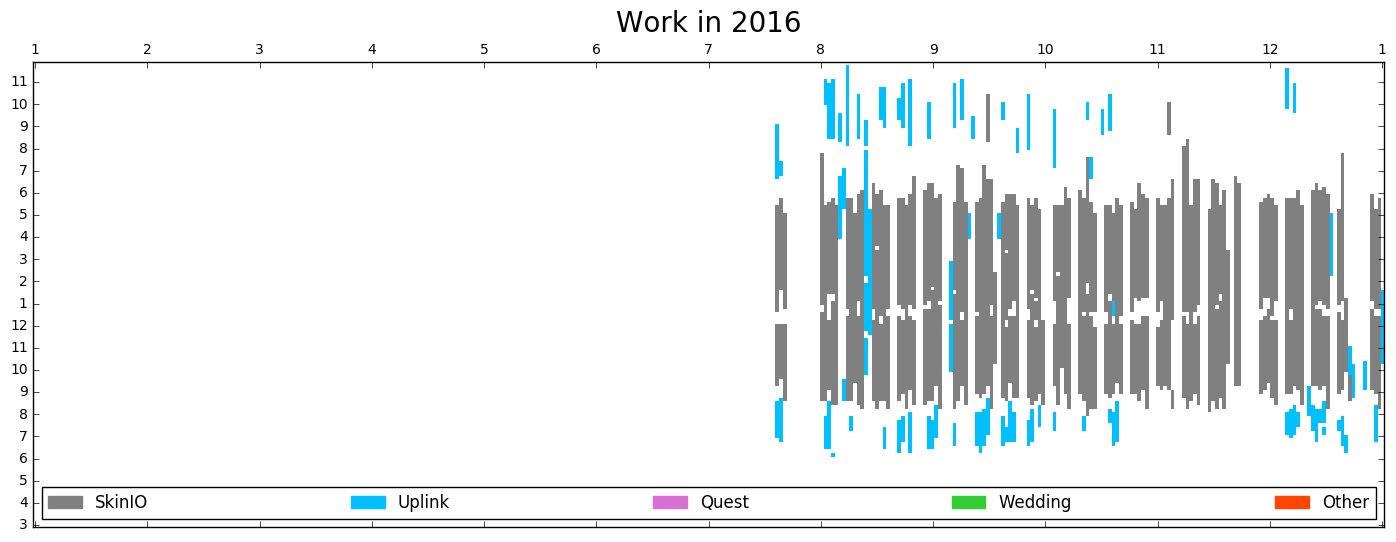

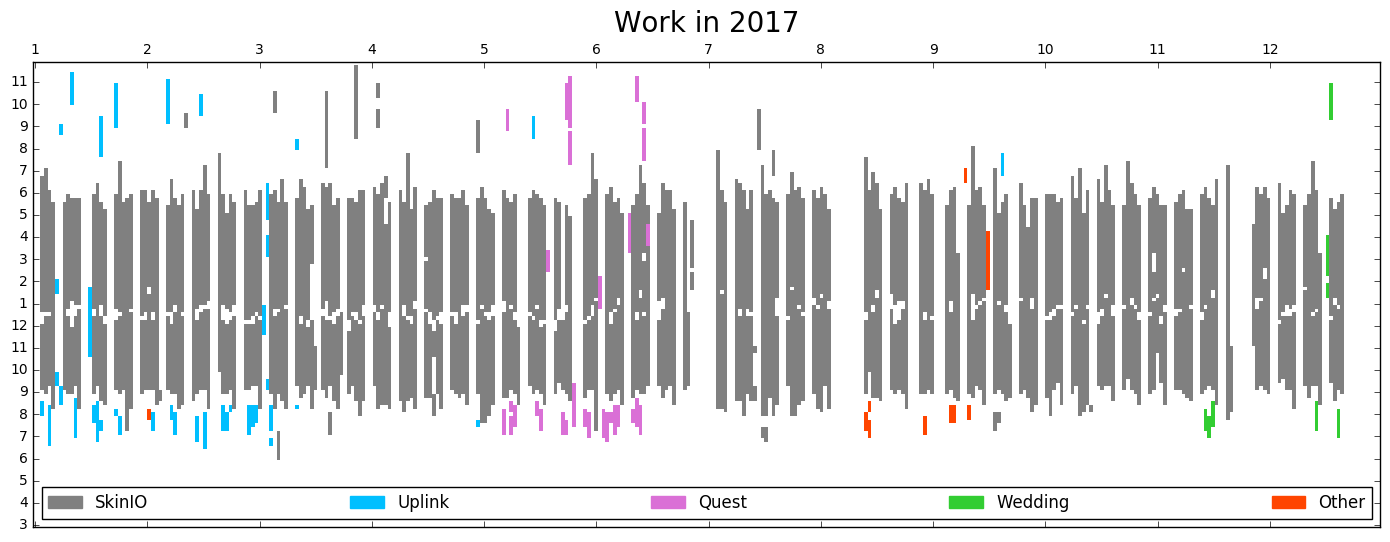

In [35]:
GROUPS_PER_HOUR = 6
START_HOUR = 3

year_matrix_2016 = generate_year_matrix(GROUPS_PER_HOUR, START_HOUR, 2016, "2016-Records.csv")
year_matrix_2017 = generate_year_matrix(GROUPS_PER_HOUR, START_HOUR, 2017)

display_year_matrix("Work in 2016", year_matrix_2016, START_HOUR)
display_year_matrix("Work in 2017", year_matrix_2017, START_HOUR)